In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os

In [27]:
# Here we collect the hyperparameters we are going to use
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1,
                       lr=0.01, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [43]:
def apply_colors(tensor):
    mask = tensor > 0
    color = torch.rand(3, 1, 1)
    color_tensor = torch.zeros((3, tensor.shape[1], tensor.shape[2]))
    
    # skalowanie kolorów
    for i in range(3):
        color_tensor[i] = tensor[0] * color[i]
    
    # dodaje kolor do nie czarnych pikeli
    color_tensor[:, ~mask[0]] = 0
    
    return color_tensor

In [44]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: apply_colors(x) 
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: apply_colors(x)
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [45]:
train_loader.dataset[1][0].size()

torch.Size([3, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.4887288].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.3002238].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5545163].


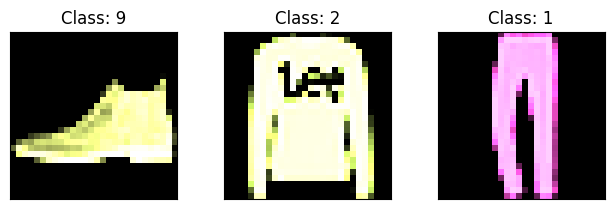

In [47]:
fig = plt.figure()
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(test_loader.dataset[i][0].numpy(), (1, 2, 0)))
    plt.title(f"Class: {test_loader.dataset[i][1]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..1.882542].


Batch of images: torch.Size([64, 3, 28, 28])
Batch of labels: torch.Size([64])


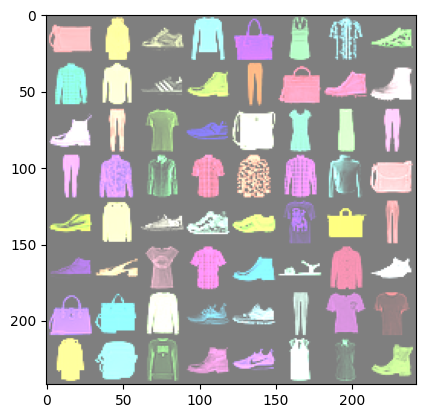

Labels:     8     4     7     2     8     0     6     7     6     6     7     9     1     8     9     9     9     1     0     7     8     3     3     1     1     4     6     6     4     6     2     8     9     2     7     7     7     0     8     1     7     5     0     6     9     5     4     7     8     8     2     7     7     1     0     0     4     8     2     9     7     3     6     9


In [48]:
import matplotlib.pyplot as plt
import torchvision

# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print and display images
print('Batch of images:', images.shape)
print('Batch of labels:', labels.shape)
imshow(torchvision.utils.make_grid(images))

# Print a few labels to verify
print('Labels:', ' '.join('%5s' % labels[j].item() for j in range(len(labels))))



In [49]:
def number_to_binary_vector(number):
    binary_vector = [0] * 10
    binary_vector[number] = 1
    return binary_vector

def spatial_label_to_vector(label):
    binary_vector = [0] * 4
    if label == "left":
        binary_vector[0] = 1
    elif label == "above":
        binary_vector[1] = 1
    elif label == "below left":
        binary_vector[2] = 1
    if label == "below right":
        binary_vector[3] = 1
    return binary_vector

def outcomeVector(label_1, label_2, spatial_label):
    if spatial_label == "above right":
        label_1, label_2 = label_2, label_1
        spatial_label = "below left"
    elif spatial_label == "above left":
        label_1, label_2 = label_2, label_1
        spatial_label = "below right"
    vector1 = number_to_binary_vector(label_1)
    vector2 = number_to_binary_vector(label_2)
    vector12 = np.concatenate((vector1, vector2))
    vector3 = spatial_label_to_vector(spatial_label)
    vector = np.concatenate((vector12, vector3))
    return vector

def spatial_relation_labels(x1,y1,x2,y2):
    
    if y1 == y2:
        label = "left"
    elif x1 == x2:
        label = "above"
    elif x1< x2 and y1 < y2:
        label = "above left"
    elif x1 > x2 and y1 < y2:
        label = "above right"
    else:
        label = "below left"
    return label

In [50]:
def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    # creates a number of images containing three random items from FashionMNIST dataset with two vectors of 10 binary values, 
    # which encode names of the two items in the image and their spatial relation, and the name of the spatial relation between
    # the two items 
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(3, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while True:
            if label_1 == label_2:
                idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
                img2, label_2 = train_loader.dataset[idx2]
                continue
            else:
                break

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)

        if a >= 0:
            x1 = a
            y1 = 0
        else:
            x1 = 0
            y1 = abs(a)
        
        if x1 > 0 and y1 == 0:
            y2 = 27
            x2 = np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2 = b
                y2 = 27
            else:
                x2 = 27
                y2 = 55 - b
        else:
            x2 = 27
            y2 = np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        spatial_label = spatial_relation_labels(x1,y1,x2,y2)
        vector = outcomeVector(label_1, label_2, spatial_label)

        samples.append((background, vector))

    return samples

## Examples

Example nr 1: 
Input: 


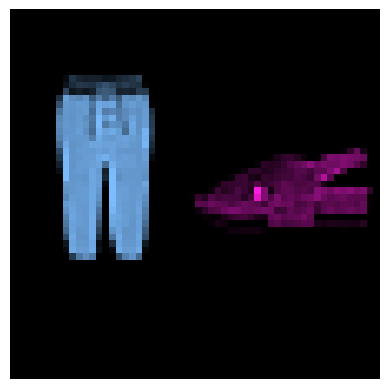

Output:  [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1] 

Example nr 2: 
Input: 


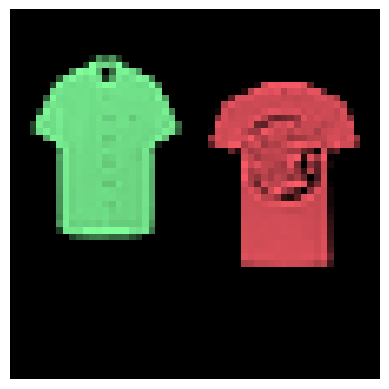

Output:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1] 

Example nr 3: 
Input: 


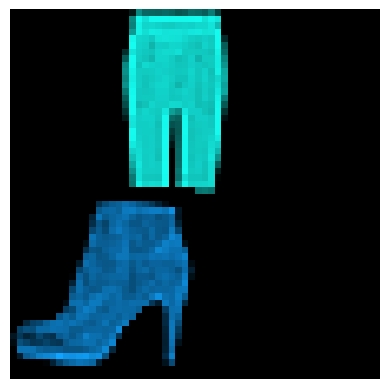

Output:  [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0] 

Example nr 4: 
Input: 


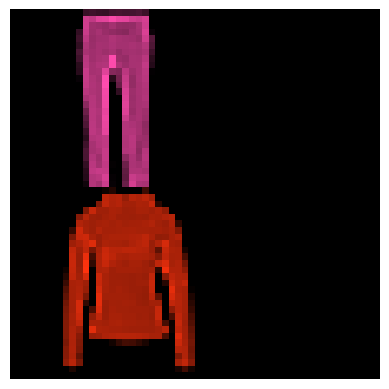

Output:  [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1] 

Example nr 5: 
Input: 


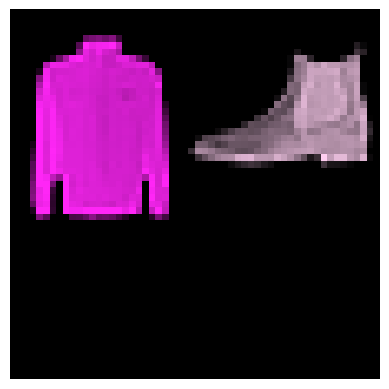

Output:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0] 



In [51]:
samples = create_samples_with_non_overlapping_images_and_vectors(train_loader,5)

for i in range(5):
    img, vector = samples[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Output: ", vector,"\n")    